<a href="https://colab.research.google.com/github/ShaleBale/SeaIce/blob/main/sea_ice_test_SAM_Rasterio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 48.1 MB/s eta 0:00:00


In [2]:
import rasterio

In [3]:
pip install descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm, trange
import cv2

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label, binary_dilation, binary_erosion, reconstruction
from skimage.measure import regionprops, regionprops_table
from skimage import measure
from skimage.segmentation import watershed

from shapely.geometry import Polygon, LineString
from shapely.affinity import scale
from descartes import PolygonPatch

import scipy.ndimage as ndi
import scipy.interpolate

import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img

from glob import glob

In [5]:
!pip install gdal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Using open cv - cv.imshow does not work in colab, must use google patch with cv2_imshow. We load the image with GDAL to maintain georeference capabilities.

In [7]:
img_path = '/content/gdrive/MyDrive/SeaIce/Exports/Final_p10_168/c168_SHIFT_p10_Clip.tif'
mask_path = '/content/gdrive/MyDrive/SeaIce/SAM/Test_Final_Ras_GS.tif'

In [8]:
img = rasterio.open(img_path)
mask = rasterio.open(mask_path)

In [9]:
type(mask)

rasterio.io.DatasetReader

Open CV defaults to reading a BGR image, therefore the displayed image of our ice is defaulted to the first three channels (band 1, band 2, and band 3).

In [10]:
band1 = img.read(1)
band2 = img.read(2)
band3 = img.read(3)
band4 = img.read(4)
image_vis = np.stack([band1, band2, band3], axis=-1)

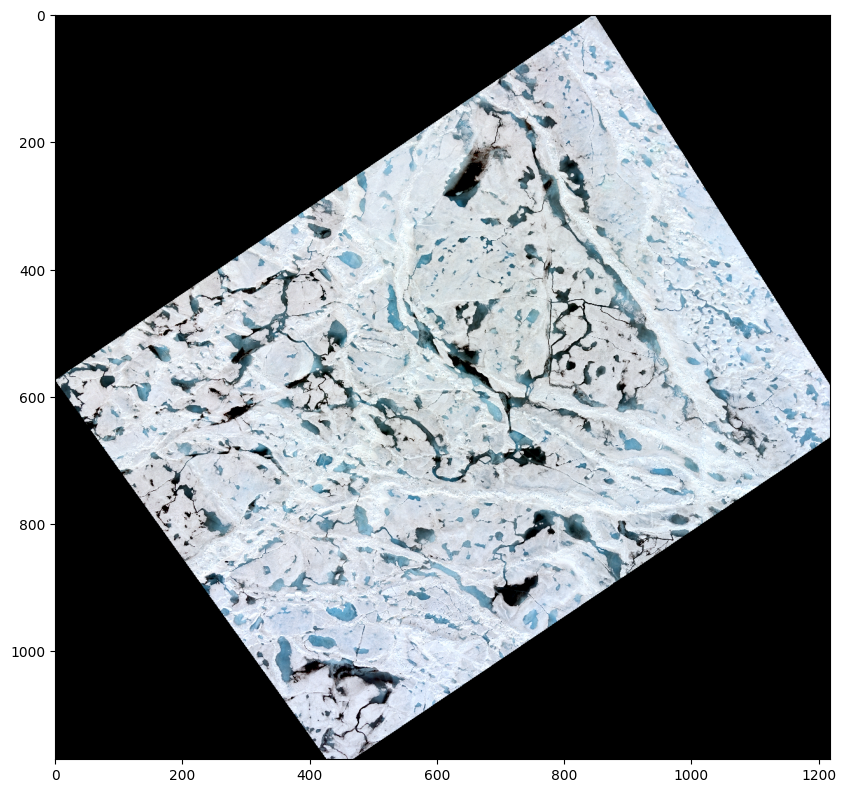

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(image_vis)
plt.axis('on')
plt.show()

We can see that our array shape includes 4 channels, where the fourth band represents the NIR.

In [12]:
image_RGBN = np.stack([band1, band2, band3, band4], axis=-1)

In [13]:
image_RGBN.shape

(1170, 1218, 4)

We now try to load the mask raster.

In [14]:
mask.meta

{'driver': 'GTiff',
 'dtype': 'int8',
 'nodata': -128.0,
 'width': 1253,
 'height': 1187,
 'count': 1,
 'crs': CRS.from_epsg(32621),
 'transform': Affine(0.5, 0.0, 407427.5630000001,
        0.0, -0.5, 9332545.166565312)}

In [15]:
mask.indexes

(1,)

In [16]:
mask_grey_band = mask.read(1)
mask_grey = np.stack([mask_grey_band], axis=-1)

In [17]:
np.unique(mask_grey)

array([-128,    1,    2,  100,  101], dtype=int8)

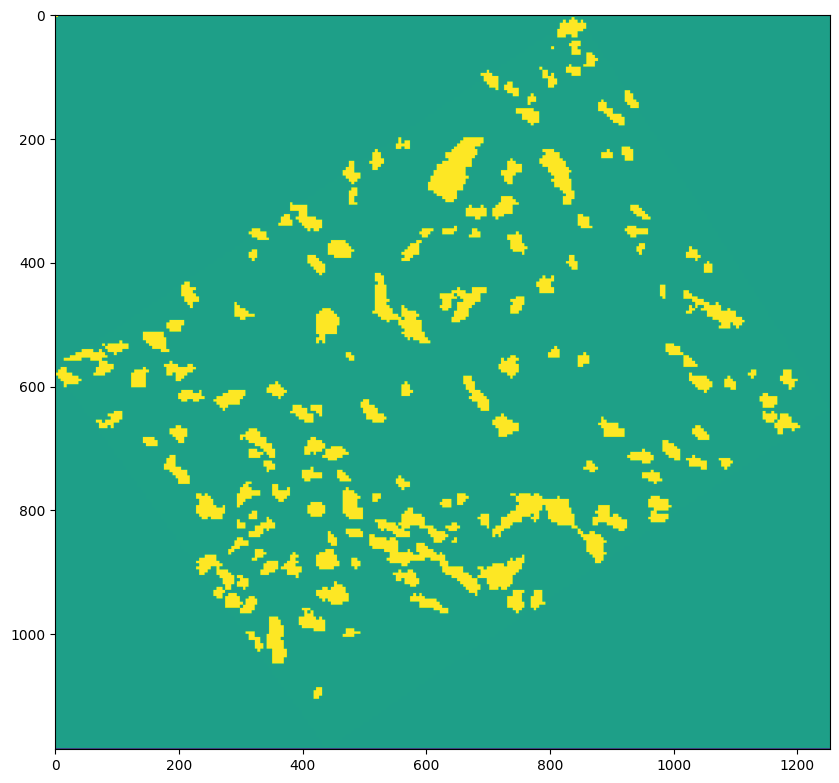

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(mask_grey)
plt.axis('on')
plt.show()

In [19]:
mask_grey.shape

(1187, 1253, 1)

In [20]:
type(mask_grey)

numpy.ndarray

In [21]:
np.unique(mask_grey)

array([-128,    1,    2,  100,  101], dtype=int8)

In [22]:
image_RGBN.shape

(1170, 1218, 4)

We see that the mask shape is much larger than the image shape. This is because the mask was originally generated on a full size tiff of the image, however, for modeling puposes we are using a p10 version of this image to conserve computational resources. The mask must be resized first to match our p10 image size.

In [23]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 91.2 MB/s eta 0:00:00


In [24]:
import geopandas as gpd
from rasterio import features

In [25]:
from rasterio import Affine

In [26]:
from rasterio.enums import Resampling

Resizing the mask image to match the original image. Nearest Neigbors is used to retain the original values

In [27]:
with rasterio.open(mask_path) as src:
    new_height = 1170
    new_width = 1218
    scale_factor_x = src.width / new_width
    scale_factor_y = src.height / new_height
    out_transform = src.transform * src.transform.scale(scale_factor_x, scale_factor_y)
    
    kwargs = src.meta.copy()
    kwargs.update({
        'transform': out_transform,
        'height': new_height,
        'width': new_width
    })
    
    with rasterio.open('/content/gdrive/MyDrive/SeaIce/SAM/Test_Final_Ras_GS_RESIZE.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            rasterio.warp.reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=out_transform,
                dst_crs=src.crs,
                resampling=Resampling.nearest
            )
            
src.close()
dst.close()

In [28]:
mask_resize = rasterio.open('/content/gdrive/MyDrive/SeaIce/SAM/Test_Final_Ras_GS_RESIZE.tif')

In [29]:
mask_resize.shape

(1170, 1218)

In [30]:
mask_resize.meta

{'driver': 'GTiff',
 'dtype': 'int8',
 'nodata': -128.0,
 'width': 1218,
 'height': 1170,
 'count': 1,
 'crs': CRS.from_epsg(32621),
 'transform': Affine(0.514367816091954, 0.0, 407427.5630000001,
        0.0, -0.5072649572649572, 9332545.166565312)}

In [31]:
image_RGBN.shape

(1170, 1218, 4)

In [32]:
mask_grey_band_resize = mask_resize.read(1)
mask_grey_resized = np.stack([mask_grey_band_resize], axis=-1)

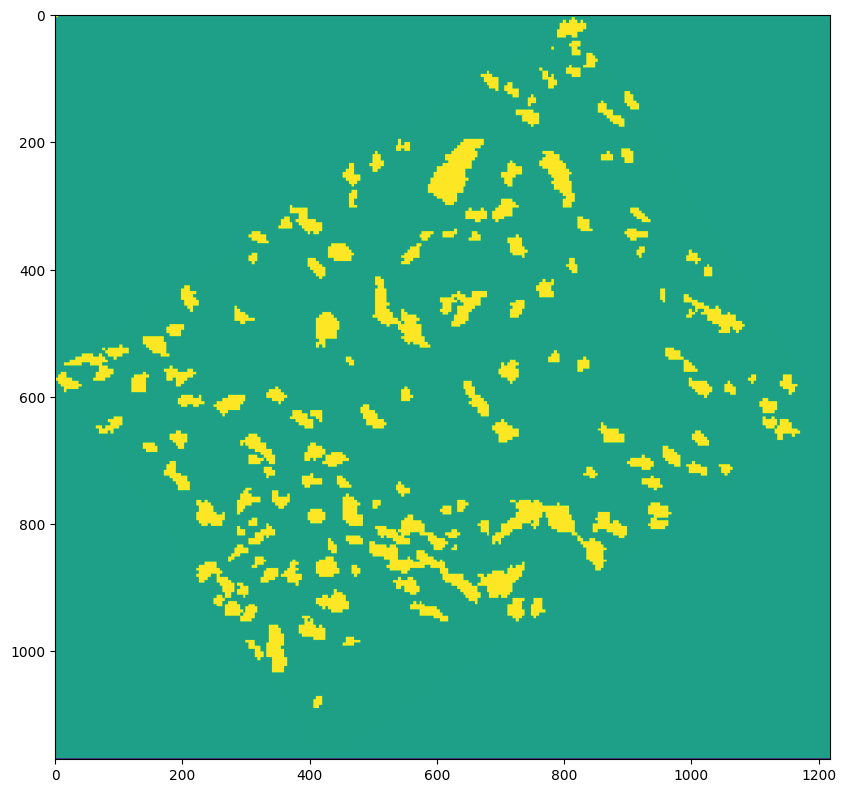

In [33]:
plt.figure(figsize=(10,10))
plt.imshow(mask_grey_resized)
plt.axis('on')
plt.show()

In [34]:
mask_grey_resized.shape

(1170, 1218, 1)

In [35]:
np.unique(mask_grey_resized)

array([-128,    1,    2,  100,  101], dtype=int8)

In [36]:
grey_mask_arr = mask_grey_resized.copy()

In [37]:
np.unique(grey_mask_arr)

array([-128,    1,    2,  100,  101], dtype=int8)

In [38]:
grey_mask_arr[(grey_mask_arr == -128) | (grey_mask_arr == 1) | (grey_mask_arr == 100)] = 0      ## 0 represents no data
grey_mask_arr[grey_mask_arr == 101] = -100                                                      ## -100 represnts ponds
grey_mask_arr[grey_mask_arr == 2] = 100                                                         ## 100 represents ice

In [39]:
np.unique(grey_mask_arr)

array([-100,    0,  100], dtype=int8)

In [40]:
type(grey_mask_arr)

numpy.ndarray

In [ ]:
## could potentially copy array in as float

We create a 3 channel grey mask in cv2 by setting all nodata values to 0, ice values to 100, and pond values to 255.

In [41]:
grey_mask_arr.shape

(1170, 1218, 1)

In [42]:
np.unique(grey_mask_arr)

array([-100,    0,  100], dtype=int8)

In [ ]:
## maybe make this a single band mask instead of a three band mask 

In [43]:
new_arr = np.zeros((grey_mask_arr.shape[0], grey_mask_arr.shape[1]), dtype=np.float32)
new_arr.shape

(1170, 1218)

In [44]:
# set the first channel to 0 where the original array is zero ---------------> therefore, 0 will represent no data
new_arr[grey_mask_arr[:,:,0] == 0] = np.nan

# set the second channel to 255 where the original array is -100 ------------> therefore, 255 will represent ponds
new_arr[grey_mask_arr[:,:,0] == -100] = 255

# set the third channel to 100 where the original array is 100 --------------> therefore, 100 will represent ice
new_arr[grey_mask_arr[:,:,0] == 100] = 100

In [45]:
new_arr.shape

(1170, 1218)

In [46]:
np.unique(new_arr)

array([100., 255.,  nan], dtype=float32)

In [90]:
# Get the unique values in new_arr
unique_vals = np.unique(new_arr)

# Create a new array with one channel for each unique value
# new_arr_3band = np.zeros((grey_mask_arr.shape[0], grey_mask_arr.shape[1], len(unique_vals)), dtype=np.float32)
new_arr_3band = np.full((grey_mask_arr.shape[0], grey_mask_arr.shape[1], len(unique_vals)), np.nan, dtype=np.float32)

# Assign each unique value to its own channel
for i, val in enumerate(unique_vals):
    new_arr_3band[:,:,i] = np.where(new_arr == val, val, np.nan)

# Set up the metadata for the output raster
meta = {
    "driver": "GTiff",
    "dtype": rasterio.float32,
    "count": 3,
    "height": grey_mask_arr.shape[0],
    "width": grey_mask_arr.shape[1],
    "crs": rasterio.crs.CRS.from_epsg(32621),
    "transform": Affine(0.514367816091954, 0.0, 407427.5630000001,
        0.0, -0.5072649572649572, 9332545.166565312),
    "nodata": np.nan
}


# Save the new array as a GeoTIFF file with one band for each unique value
with rasterio.open('/content/gdrive/MyDrive/SeaIce/SAM/Resized_3Band.tif', "w", **meta) as dst:
    for i, val in enumerate(unique_vals):
        dst.write(new_arr_3band[:,:,i], i+1)


In [91]:
new_mask_path = '/content/gdrive/MyDrive/SeaIce/SAM/Resized_3Band.tif'

In [92]:
new_mask = rasterio.open(new_mask_path)

In [93]:
new_mask.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': nan,
 'width': 1218,
 'height': 1170,
 'count': 3,
 'crs': CRS.from_epsg(32621),
 'transform': Affine(0.514367816091954, 0.0, 407427.5630000001,
        0.0, -0.5072649572649572, 9332545.166565312)}

In [94]:
band1_new_mask = new_mask.read(1)
band2_new_mask = new_mask.read(2)
band3_new_mask = new_mask.read(3)

mask_stack = np.stack([band1, band2, band3], axis=-1)

In [95]:
np.unique(band1_new_mask)

array([100.,  nan], dtype=float32)

In [96]:
np.unique(band2_new_mask)

array([255.,  nan], dtype=float32)

In [97]:
np.unique(band3_new_mask)

array([nan], dtype=float32)

In [98]:
mask_stack.shape

(1170, 1218, 3)

In [99]:
np.unique(mask_stack)

array([  0,   1,   6,   9,  11,  13,  15,  17,  19,  20,  22,  25,  28,
        29,  31,  32,  33,  34,  35,  36,  38,  39,  41,  42,  43,  44,
        45,  46,  47,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
        59,  60,  62,  63,  64,  66,  68,  69,  70,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 20

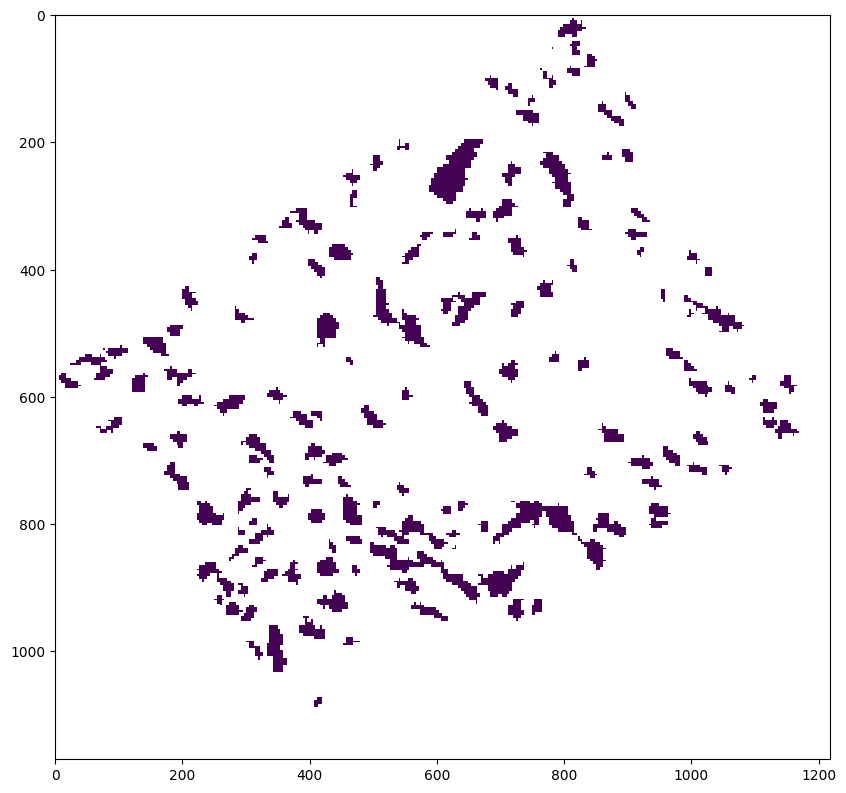

In [102]:
plt.figure(figsize=(10,10))
plt.imshow(band2_new_mask)
plt.axis('on')
plt.show()

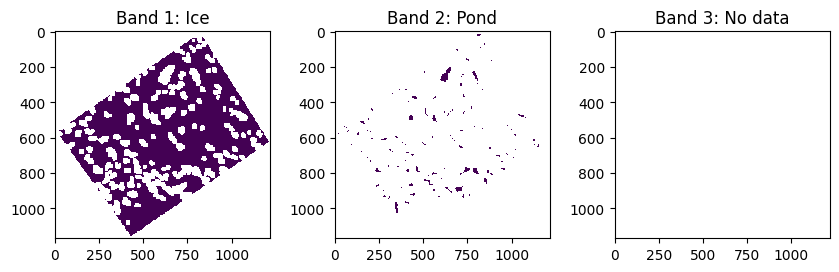

In [101]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))


axes[0].imshow(band1_new_mask)
axes[0].set_title('Band 1: Ice')

# Display the second image in the second subplot
axes[1].imshow(band2_new_mask)
axes[1].set_title('Band 2: Pond')

# Display the third image in the third subplot
axes[2].imshow(band3_new_mask)
axes[2].set_title('Band 3: No data')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Display the figure
plt.show()

In [56]:
def plot_images_and_labels(img, label):
  fig = plt.figure(figsize = (12, 4))
  
  ax1 = fig.add_subplot(131)
  ax1.imshow(img[:,:])
  ax1.set_title("Sea Ice")
  ax1.set_xticks([])
  ax1.set_yticks([])
  
  ax2 = fig.add_subplot(132)
  ax2.imshow(label[:,:])
  ax2.set_title("Label")
  ax2.set_xticks([])
  ax2.set_yticks([])
  
  dst = cv2.addWeighted(img, 0.5, label, 0.5, 0)
  
  ax3 = fig.add_subplot(133)
  ax3.imshow(dst[:,:])
  ax3.set_title("Blending")
  ax3.set_xticks([])
  ax3.set_yticks([])

We look to see how the blended image of the Sea Ice (using the first three channels) and the three-channel gray image blend.

In [ ]:
plot_images_and_labels(img[:,:, 0:3], band3_new_mask)

TypeError: ignored

We only have one image and one mask, so to improve results we tile the image to generate more training data.

In [ ]:
!mkdir Tiles

In [ ]:
cd Tiles

In [ ]:
!mkdir images
!mkdir labels

In [ ]:
cd ..

In [ ]:
ls

In [ ]:
# break up large images into small squares:
start_no = 0
im_size = 256

# if len(np.shape(img))==3:
#   image = img[:,:,0]
# if len(np.shape(grey_3_channel_mask))==3:
#   lab = grey_3_channel_mask[:,:,0]

r, c, z = np.shape(img)
n_rows = int(np.floor(r/float(im_size)))
n_cols = int(np.floor(c/float(im_size)))


# write files for segmented images:
for i in trange(n_rows):
    for j in range(n_cols):
        im = img[i*im_size:(i+1)*im_size, j*im_size:(j+1)*im_size, :].astype('uint8')
        imname = 'Tiles/images/' + 'im%03d.png'%(start_no+n_cols*i+j)
        m = grey_3_channel_mask[i*im_size:(i+1)*im_size, j*im_size:(j+1)*im_size].astype('uint8')
        labname = 'Tiles/labels/' + 'im%03d.png'%(start_no+n_cols*i+j)
        
        # if np.max(m)>0: # only save images that have more than just background
        im = Image.fromarray(im.astype(np.uint8))
        im.save(imname)
        m = Image.fromarray(m.astype(np.uint8))
        m.save(labname)

start_no = start_no + n_rows*n_cols

In [ ]:
from glob import glob
images = sorted(glob("Tiles/images/*.png"))
labels = sorted(glob("Tiles/labels/*.png")) 

In [ ]:
for i in range(len(images)):
  print('img_tile: {} | label_tile: {}'.format(images[i], labels[i]))

In [ ]:
for i in range(len(images)):
  fname = images[i]
  tile = cv2.imread(fname)
  lab = cv2.imread(fname.replace('images', 'labels'))
  plot_images_and_labels(tile, lab)

We use image augmentation to enchance the number of training data we have.

In [ ]:
!pip install clodsa

In [ ]:
pip install numpy --upgrade # this needs to be run twice for some reason??? Otherwise next cell won't work.

In [ ]:
from clodsa.augmentors.augmentorFactory import createAugmentor
from clodsa.transformers.transformerFactory import transformerGenerator
from clodsa.techniques.techniqueFactory import createTechnique

In [ ]:
PROBLEM = "semantic_segmentation"
ANNOTATION_MODE = "folders"
INPUT_PATH = "/content/Tiles/"
GENERATION_MODE = "linear" # all the augmentation techniques are applied to all the images of the original dataset
OUTPUT_MODE = "folders"
OUTPUT_PATH= "/content/augmented_images2/"
LABELS_EXTENSION = ".png"

augmentor = createAugmentor(PROBLEM, ANNOTATION_MODE, OUTPUT_MODE, GENERATION_MODE, INPUT_PATH,{"outputPath":OUTPUT_PATH,"labelsExtension":LABELS_EXTENSION})

In [ ]:
transformer = transformerGenerator(PROBLEM) # initialize a transformer

In [ ]:
# rotate images
rot90 = createTechnique("rotate", {"angle" : 90})
augmentor.addTransformer(transformer(rot90))
rot180 = createTechnique("rotate", {"angle" : 180})
augmentor.addTransformer(transformer(rot180))
rot270 = createTechnique("rotate", {"angle" : 270})
augmentor.addTransformer(transformer(rot270))

In [ ]:
gamma = createTechnique("gamma",{"gamma":1.5})
augmentor.addTransformer(transformer(gamma))

In [ ]:
gamma1 = createTechnique("gamma",{"gamma":2.0})
augmentor.addTransformer(transformer(gamma1))

In [ ]:
gamma2 = createTechnique("gamma",{"gamma":0.5})
augmentor.addTransformer(transformer(gamma2))

In [ ]:
none = createTechnique("none",{}) # need to copy the original images as well!
augmentor.addTransformer(transformer(none))

In [ ]:
fliph = createTechnique("flip",{"flip":1})
flipv = createTechnique("flip",{"flip":0})
augmentor.addTransformer(transformer(fliph))
augmentor.addTransformer(transformer(flipv))

In [ ]:
# equalize histo
equalize = createTechnique("equalize_histogram", {})
augmentor.addTransformer(transformer(equalize))

In [ ]:
salt_and_pepper = createTechnique("salt_and_pepper",{"low":0, 'high': 255})
augmentor.addTransformer(transformer(salt_and_pepper))

In [ ]:
median = createTechnique("median_blur",{"kernel":3})
augmentor.addTransformer(transformer(median))

In [ ]:
dropout = createTechnique("dropout",{"percentage":0.05})
augmentor.addTransformer(transformer(gamma2))

In [ ]:
invert = createTechnique("invert",{})
augmentor.addTransformer(transformer(invert))

In [ ]:
len(augmentor.transformers)

In [ ]:
augmentor.applyAugmentation() # apply the augmentation; this takes a while

In [ ]:
images = sorted(glob("/content/augmented_images2/images/*.png"))
labels = sorted(glob("/content/augmented_images2/labels/*.png")) 

In [ ]:
len(images)

In [ ]:
for i in range(15):
  fname = images[i]
  fname2 = labels[i]
  tile = cv2.imread(fname)
  lab = cv2.imread(fname2)
  plot_images_and_labels(tile, lab)

Now we start working on the model.

In [ ]:
############### change this ratio
# split 70% into training
train_idx = np.random.choice(np.arange(len(images)), size = int(len(images)*0.7) , replace=False)

# get the rest
idx = np.setdiff1d(np.arange(len(images)), train_idx)

# get val files (20% of total)
val_idx = np.random.choice(idx, size = int(len(images)*0.2) , replace=False)

# get test files (10% of total)
test_idx = np.setdiff1d(val_idx, train_idx)

In [ ]:
def image_batch_generator(files, im_size, batch_size = 8):
  
  while True: # this is here because it will be called repeatedly by the training function
    
    # extract a random subset of files of length "batch_size"
    batch = np.random.choice(files, size = batch_size)    
    
    # variables for collecting batches of inputs (x) and outputs (y)
    batch_x = []
    batch_y = []
    
    #cycle through each image in the batch
    for f in batch:
        # open the image and resize
        image = cv2.imread(f) #replaced pillow Image with cv2
        image = image[:,:,:]/255.0 # scale input image to (0, 1)
        # image = np.expand_dims(image,2)
        batch_x.append(image) 

        # open label image by string substitution
        mask = cv2.imread(f.replace('/images/','/labels/')) #replaced pillow Image with cv2
        mask = mask[:,:,0]
        temp = np.zeros((im_size, im_size, 3)) # create expanded target with channels for 3 classes
        temp[:,:,0][mask==0] = 1 # no data
        temp[:,:,1][mask==100] = 1 # ice
        temp[:,:,2][mask==255] = 1 # pond
        mask = temp
        batch_y.append(mask)

    # turn into numpy arrays
    batch_x = np.array(batch_x) 
    batch_y = np.array(batch_y)

    yield (batch_x, batch_y) #yield both the image and the label together

In [ ]:
gen = image_batch_generator(images, im_size = 256, batch_size = 8)

In [ ]:
x1, y1 = next(gen)

plt.figure(figsize=(15,15))

counter = 0
for k in range(8):
  plt.subplot(4,4,counter+1)
  plt.imshow(x1[counter])
  plt.imshow(y1[counter][:,:,2], alpha=0.5, cmap=plt.cm.Reds) #adjusted to 2 index to highlight ponds
  plt.axis('off')
  counter += 1

In [ ]:
np.shape(x1[0]) # image

In [ ]:
np.shape(y1[0]) # label

In [ ]:
# create arrays of training, validation, and test files (these are filenames)
train_files = np.array(images)[train_idx]
val_files = np.array(images)[val_idx]
test_files = np.array(images)[test_idx]

In [ ]:
train_files[:5]

In [ ]:
train_test = plt.imread(train_files[0])
train_test.shape

In [ ]:
val_test = plt.imread(val_files[0])
val_test.shape

In [ ]:
im_size = 256
batch_size = 8

train_generator = image_batch_generator(train_files, im_size, batch_size = batch_size) # call the batch generator for train set
val_generator  = image_batch_generator(val_files, im_size, batch_size = batch_size) # call batch generator validation set

train_steps = len(train_files)//batch_size # number of steps per training epoch
val_steps = len(val_files)//batch_size # number of steps per validation epoch

print(train_steps)
print(val_steps)

In [ ]:
np.unique(y1[2][:,:,1])

In [ ]:
y1.shape

In [ ]:
plt.imshow(y1[0, :, :, 0])
plt.colorbar()
plt.title('Nodata/Background Layer')

In [ ]:
plt.imshow(y1[0, :, :, 1])
plt.colorbar()
plt.title('Nonpond Layer')

In [ ]:
plt.imshow(y1[0, :, :, 2])
plt.colorbar()
plt.title('Pond Layer')

In [ ]:
# get an idea about class balance
nodata_fractions = []
pond_fractions = []
nonpond_fractions = []

count = 0

while count < 100:
  x1, y1 = next(gen)
  
  for i in range(8):
    
    nonpond_fraction = len(np.where(y1[i][:,:,1]==1)[0])/(256**2)
    nonpond_fractions.append(nonpond_fraction)

    pond_fraction = len(np.where(y1[i][:,:,2]==1)[0])/(256**2)
    pond_fractions.append(pond_fraction)

    nodata_fractions.append(1 - pond_fraction - nonpond_fraction)
  
  count += 1 

In [ ]:
print(1/(3*np.mean(nodata_fractions)), 1/(3*np.mean(nonpond_fractions)),  1/(3*np.mean(pond_fractions)))
# background, pond, non-pond

In [ ]:
unique, counts = np.unique(grey_mask, return_counts=True)
print('unique: {} | counts: {}'.format(unique, counts))

print('% nodata = {}'.format(100*counts[0]/sum(counts)))
print('% nonpond = {}'.format(100*counts[1]/sum(counts)))
print('% pond = {}'.format(100*counts[2]/sum(counts)))

In [ ]:
#### Calculating weights a different way
import sklearn as sk
from sklearn.utils import class_weight

In [ ]:
class_weights = sk.utils.class_weight.compute_class_weight('balanced', classes = np.unique(grey_mask), y = np.ravel(grey_mask))
class_weights

In [ ]:
def weighted_crossentropy(y_true, y_pred):
    class_weights = tf.constant([[[0.71066734,  0.65649669, 14.36060221]]]) #### this order needs to match y1 label layers index
    unweighted_losses = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    weights = tf.reduce_sum(class_weights * y_true, axis=-1) # sum of weights
    weighted_losses = weights * unweighted_losses # weighted losses
    loss = tf.reduce_mean(weighted_losses) # mean loss
    return loss

In [ ]:
def Unet():
    tf.keras.backend.clear_session()

    image = tf.keras.Input((256,256,3),name='input') #changed to 3 to match rgb image input size

    conv1 = Conv2D(16, (3,3), activation='relu', padding = 'same')(image)
    conv1 = BatchNormalization()(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32, (3,3), activation='relu', padding = 'same')(pool1)
    conv2 = BatchNormalization()(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64, (3,3), activation='relu', padding = 'same')(pool2)
    conv3 = BatchNormalization()(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(128, (3,3), activation='relu', padding = 'same')(pool3)
    conv4 = BatchNormalization()(conv4)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(256, (3,3), activation='relu', padding = 'same')(pool4)
    conv5 = BatchNormalization()(conv5)

    up6 = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(128, (3,3), activation='relu', padding = 'same')(up6)
    conv6 = BatchNormalization()(conv6)

    up7 = Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = 'same')(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(64, (3,3), activation='relu', padding = 'same')(up7)
    conv7 = BatchNormalization()(conv7)

    up8 = Conv2DTranspose(32, (3, 3), strides = (2, 2), padding = 'same')(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(32, (3,3), activation='relu', padding = 'same')(up8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = 'same')(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(16, (3,3), activation='relu', padding = 'same')(up9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(3, (1,1), activation='softmax')(conv9)
    model = Model(inputs=[image], outputs=[conv10])

    return model

In [ ]:
model = Unet()
loss = weighted_crossentropy
model.compile(optimizer=Adam(), loss=loss, metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
from keras.utils import plot_model
plot_model(model,show_shapes=True)

In [ ]:
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model_1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(train_generator, 
                epochs = 100, steps_per_epoch = train_steps,
                validation_data = val_generator, validation_steps = val_steps,
                callbacks = callbacks)	

In [ ]:
# with batch normalization
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
# load the best model
model=Unet()
model.load_weights('model_1.h5')
loss = weighted_crossentropy
model.compile(optimizer=Adam(), loss=loss, metrics=["accuracy"])

In [ ]:
test_generator = image_batch_generator(test_files, im_size, batch_size = batch_size)
print("# test files: %i" % (len(test_files)))
# some other training parameters
steps = len(test_files) // batch_size
# testing
scores = model.evaluate(test_generator, steps=steps) 

In [ ]:
print(model.metrics_names)
print(scores)

We can see that our training accuracy is higher than our test and validation accuracies, indicating some possible overfitting. We can try to fix this by adding dropout layers in the Unet model.

In [ ]:
def Unet_dropout():
    tf.keras.backend.clear_session()

    image = tf.keras.Input((256,256,3),name='input')

    conv1 = Conv2D(16, (3,3), activation='relu', padding = 'same')(image)
    conv1 = BatchNormalization()(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1) ### added dropout
    conv2 = Conv2D(32, (3,3), activation='relu', padding = 'same')(pool1)
    conv2 = BatchNormalization()(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2) ### added dropout
    conv3 = Conv2D(64, (3,3), activation='relu', padding = 'same')(pool2)
    conv3 = BatchNormalization()(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3) ### added dropout
    conv4 = Conv2D(128, (3,3), activation='relu', padding = 'same')(pool3)
    conv4 = BatchNormalization()(conv4)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4) ### added dropout
    conv5 = Conv2D(256, (3,3), activation='relu', padding = 'same')(pool4)
    conv5 = BatchNormalization()(conv5)

    up6 = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(conv5)
    up6 = concatenate([up6, conv4])
    up6 = Dropout(0.5)(up6)
    conv6 = Conv2D(128, (3,3), activation='relu', padding = 'same')(up6)
    conv6 = BatchNormalization()(conv6)

    up7 = Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = 'same')(conv6)
    up7 = concatenate([up7, conv3])
    up7 = Dropout(0.5)(up7)
    conv7 = Conv2D(64, (3,3), activation='relu', padding = 'same')(up7)
    conv7 = BatchNormalization()(conv7)

    up8 = Conv2DTranspose(32, (3, 3), strides = (2, 2), padding = 'same')(conv7)
    up8 = concatenate([up8, conv2])
    up8 = Dropout(0.5)(up8)
    conv8 = Conv2D(32, (3,3), activation='relu', padding = 'same')(up8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = 'same')(conv8)
    up9 = concatenate([up9, conv1])
    up9 = Dropout(0.5)(up9)
    conv9 = Conv2D(16, (3,3), activation='relu', padding = 'same')(up9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(3, (1,1), activation='softmax')(conv9)
    model = Model(inputs=[image], outputs=[conv10])

    return model

In [ ]:
model2 = Unet_dropout()
loss = weighted_crossentropy
model2.compile(optimizer=Adam(), loss=loss, metrics=["accuracy"])

In [ ]:
model2.summary()

In [ ]:
plot_model(model2,show_shapes=True)

In [ ]:
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model_1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results2 = model2.fit(train_generator, 
                epochs = 100, steps_per_epoch = train_steps,
                validation_data = val_generator, validation_steps = val_steps,
                callbacks = callbacks)	

In [ ]:
# with batch normalization and dropout
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results2.history["loss"], label="loss")
plt.plot(results2.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results2.history["val_loss"]), np.min(results2.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
# load the best model
model2=Unet()
model2.load_weights('model_1.h5')
loss = weighted_crossentropy
model2.compile(optimizer=Adam(), loss=loss, metrics=["accuracy"])

In [ ]:
test_generator = image_batch_generator(test_files, im_size, batch_size = batch_size)
print("# test files: %i" % (len(test_files)))
# some other training parameters
steps = len(test_files) // batch_size
# testing
scores = model2.evaluate(test_generator, steps=steps) 

In [ ]:
print(model2.metrics_names)
print(scores)

By adding dropout layers, we improved the overall model accuracy, however, our loss curve is still suspicious and indicates that the model is overfitting.

We can now plot the predicted labels against the image data. We start with a tile selection from the training data.

In [ ]:
from skimage.measure import regionprops, regionprops_table
from skimage.morphology import binary_dilation, binary_erosion
from shapely.geometry import Polygon, LineString
from shapely.affinity import scale
from descartes import PolygonPatch
from skimage.morphology import reconstruction
import scipy.ndimage as ndi
from skimage import measure
from skimage.segmentation import watershed
from shapely.geometry import Polygon
import scipy.interpolate
import math
from matplotlib.colors import ListedColormap


#  functions for assembling big image from prediction tiles:
def predict_image_tile(im_tile, model):
    if len(np.shape(im_tile)) == 2:
      im_tile = np.expand_dims(im_tile, axis = 2) # add dimension for channel
    
    im_tile = np.expand_dims(im_tile, axis = 0) # add dimension for batch
    
    return model.predict(im_tile, verbose=0)[0]

def predict_big_image(big_im, model, I):
    pad_rows = I - np.mod(big_im.shape[0], I)
    pad_cols = I - np.mod(big_im.shape[1], I)
    
    if len(np.shape(big_im)) == 2:
      big_im = np.vstack((big_im, np.zeros((pad_rows, big_im.shape[1]))))
      big_im = np.hstack((big_im, np.zeros((big_im.shape[0], pad_cols))))
   
    if len(np.shape(big_im)) == 3:
      big_im = np.vstack((big_im, np.zeros((pad_rows, big_im.shape[1], big_im.shape[2]))))
      big_im = np.hstack((big_im, np.zeros((big_im.shape[0], pad_cols, big_im.shape[2]))))
    
    r = int(np.floor(big_im.shape[0]/I)) # number of rows of image tiles
    c = int(np.floor(big_im.shape[1]/I)) # number of columns of image tiles

    I2 = int(I/2)
    W = np.hanning(I) * np.hanning(I)[:, np.newaxis]
    Wup = W.copy()
    Wup[:I2, :] = np.tile(np.hanning(I), (I2, 1))
    Wdown = W.copy()
    Wdown[I2:, :] = np.tile(np.hanning(I), (I2, 1))

    if len(np.shape(big_im)) == 2:
      big_im = np.hstack((np.zeros((r*I, I2)), big_im, np.zeros((r*I, I2)))) # padding on the left and right sides
   
    if len(np.shape(big_im)) == 3:
      big_im = np.hstack((np.zeros((r*I, I2, 3)), big_im, np.zeros((r*I, I2, 3)))) # padding on the left and right sides
    
    big_im_pred = np.zeros((big_im.shape[0], big_im.shape[1], 3))

    for i in trange(c+1): # rows, no offset
      for j in range(1,2*r-2): # columns
        im_tile = big_im[j*I2:(j+2)*I2, i*I:(i+1)*I]/255.0
        im_tile_pred = predict_image_tile(im_tile, model)

        for layer in range(3):
          big_im_pred[j*I2:(j+2)*I2, i*I:(i+1)*I, layer] += im_tile_pred[:, :, layer] * W
    
    for i in range(c+1): # first row
      im_tile = big_im[:2*I2, i*I:(i+1)*I]/255.0
      im_tile_pred = predict_image_tile(im_tile, model)

      for layer in range(3):
        big_im_pred[:2*I2, i*I:(i+1)*I, layer] += im_tile_pred[:, :, layer] * Wup
    
    for i in range(c+1): # last row
      im_tile = big_im[(2*r-2)*I2:2*r*I2, i*I:(i+1)*I]/255.0
      im_tile_pred = predict_image_tile(im_tile,model)

      for layer in range(3):
        big_im_pred[(2*r-2)*I2:2*r*I2, i*I:(i+1)*I, layer] += im_tile_pred[:, :, layer] * Wdown

    for i in trange(c): # rows, half offset
      for j in range(1,2*r-2): # columns
        im_tile = big_im[j*I2:(j+2)*I2, i*I+I2:(i+1)*I+I2]/255.0
        im_tile_pred = predict_image_tile(im_tile,model)

        for layer in range(3):
          big_im_pred[j*I2:(j+2)*I2, i*I+I2:(i+1)*I+I2, layer] += im_tile_pred[:, :, layer] * W
    
    for i in range(c): # first row
      im_tile = big_im[:2*I2, i*I+I2:(i+1)*I+I2]/255.0
      im_tile_pred = predict_image_tile(im_tile,model)

      for layer in range(3):
        big_im_pred[:2*I2, i*I+I2:(i+1)*I+I2, layer] += im_tile_pred[:, :, layer] * Wup
    
    for i in range(c): # last row
      im_tile = big_im[(2*r-2)*I2:2*r*I2, i*I+I2:(i+1)*I+I2]/255.0
      im_tile_pred = predict_image_tile(im_tile,model)

      for layer in range(3):
        big_im_pred[(2*r-2)*I2:2*r*I2, i*I+I2:(i+1)*I+I2, layer] += im_tile_pred[:, :, layer] * Wdown

    big_im_pred = big_im_pred[:, I2:-I2, :] # crop the left and right side padding
    big_im_pred = big_im_pred[:-pad_rows, :-pad_cols, :] # get rid of padding
    
    return big_im_pred

In [ ]:
tile = cv2.imread(images[0])
lab = cv2.imread(labels[0])
pred = predict_image_tile(tile, model2)

fig = plt.figure(figsize = (12, 4))
  
ax1 = fig.add_subplot(131)
ax1.imshow(tile[:,:])
ax1.set_title("Sea Ice")
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_subplot(132)
ax2.imshow(lab[:,:])
ax2.set_title("Label")
ax2.set_xticks([])
ax2.set_yticks([])

ax3 = fig.add_subplot(133)
ax3.imshow(pred[:,:])
ax3.set_title("Pred")
ax3.set_xticks([])
ax3.set_yticks([])



We can see that the prediction fails to identify the ponds, and instead covers labels the entire ice sheet as "nonpond" (green color). To verify, we also plot the large image.

In [ ]:
p10_168_pred = predict_big_image(img[:,:,0:3], model2, I=256)

In [ ]:
uni_pred, count_pred = np.unique(p10_168_pred, return_counts=True)
print(uni_pred, count_pred)

In [ ]:
plt.figure(figsize=(15,10))
plt.imshow(p10_168_pred[:, :, 2])
plt.colorbar(label='Probability')
plt.title('Probability of pond label')

Again, the model fails to predict ponds. This is a large indication that our model does not have enough pond data to accurately predict them from the other label classes and that our model is overfitted relative to the nonpond and nodata (background) labels. To improve this, more data for ponds would be necessary to improve the model training. 